#**Multi-label Classification**


---


### Problem Statement
Create a multi-label genre classification model using Tensorflow that automatically
assigns genre names looking at the summary of the movie.
1. Use pre-built embeddings for your data dictionary
2. Train the model using Transformer/Attention based architecture
3. Reach an overall “precision” score of 70%
4. Use TF serving to deploy the model as an API (on local)
5. Build a TF serving client to interact with the API. This client should also be able
to continuously accept data entered by the user and provide the genre for the
chat entered by the end-user.


---

### Dataset

CMU Movie Summary Corpus - http://www.cs.cmu.edu/~ark/personas/
Or download from - http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz



---


### Approach
1. We have used pre-trained BERT model from [Tenorflow Hub](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4) and finetuned it to match the number of classes i.e. genres
2. Serving is done using [Tensorflow Model Serve](https://www.tensorflow.org/tfx/guide/serving)
3. Client is build using Flask and port forwarding is done using [ngrok](https://ngrok.com/) / [flask-ngrok](https://pypi.org/project/flask-ngrok/)


##Downloading Data

We use wget to download data through a link

In [ ]:
!wget http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz

--2022-10-18 18:19:11--  http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48002242 (46M) [application/x-gzip]
Saving to: ‘MovieSummaries.tar.gz.1’

MovieSummaries.tar. 100%[===================>]  45.78M   354KB/s    in 78s     

2022-10-18 18:20:29 (602 KB/s) - ‘MovieSummaries.tar.gz.1’ saved [48002242/48002242]



Extracting the gzip file

In [ ]:
!tar -xvzf MovieSummaries.tar.gz

MovieSummaries/
MovieSummaries/tvtropes.clusters.txt
MovieSummaries/name.clusters.txt
MovieSummaries/plot_summaries.txt
MovieSummaries/README.txt
MovieSummaries/movie.metadata.tsv
MovieSummaries/character.metadata.tsv


##Cleaning Data

In [ ]:
import pandas as pd
import re

In [ ]:
# This are the columns in move.metadata.tsv file
movie_metadata_names=[ "Wikipedia movie ID",
"Freebase movie ID",
"Movie name",
"Movie release date",
"Movie box office revenue",
"Movie runtime",
"Movie languages",
"Movie countries",
"Movie genres"]

In [ ]:
#reading data
movie_metadata=pd.read_csv('/content/MovieSummaries/movie.metadata.tsv',sep='\t',names=movie_metadata_names)

In [ ]:
# Droping the unwanted columns
movie_metadata=movie_metadata.drop(columns=["Freebase movie ID",
"Movie name",
"Movie release date",
"Movie box office revenue",
"Movie runtime",
"Movie languages",
"Movie countries",])

In [ ]:
movie_metadata

,Wikipedia movie ID,Movie genres
0,975900,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,"{""/m/07s9rl0"": ""Drama""}"
...,...,...
81736,35228177,"{""/m/07s9rl0"": ""Drama""}"
81737,34980460,"{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0..."
81738,9971909,"{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}"
81739,913762,"{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ..."


In [ ]:
# Cleaning Movie genres column and converting it to list
movie_metadata["Movie genres"] = movie_metadata["Movie genres"].map(lambda genres: list(eval(genres).values()))

Reading second file

In [ ]:
plot_summaries=pd.read_csv('/content/MovieSummaries/plot_summaries.txt',sep='\t',names=["Wikipedia movie ID","Summary"])

In [ ]:
plot_summaries

,Wikipedia movie ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


In [ ]:
dataset = pd.merge(movie_metadata,plot_summaries,on="Wikipedia movie ID")

In [ ]:
dataset

,Wikipedia movie ID,Movie genres,Summary
0,975900,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
2,261236,[Drama],"Eva, an upper class housewife, becomes frustra..."
3,18998739,"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
4,6631279,"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."
...,...,...,...
42199,23851782,"[Crime Fiction, Thriller, Comedy, Supernatural]",{{plot}} The film opens with a Great Western e...
42200,35228177,[Drama],Two former National Oceanic Atmospheric Admini...
42201,34980460,"[Biographical film, Drama, Documentary]",{{No plot}} This film follows 12 years in the ...
42202,913762,"[Science Fiction, Japanese Movies, Adventure, ...","The story takes place in the year 2092,The Sup..."


In [ ]:
# removing unwanted artifacts and lower cassing the summary column
dataset["Summary"]=dataset["Summary"].str.replace("{{No plot}}","")
dataset["Summary"]=dataset["Summary"].str.replace("{{plot}}","")
dataset["Summary"]=dataset["Summary"].str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
dataset

,Wikipedia movie ID,Movie genres,Summary
0,975900,"[Thriller, Science Fiction, Horror, Adventure,...","set in the second half of the 22nd century, th..."
1,9363483,"[Thriller, Erotic thriller, Psychological thri...",a series of murders of rich young women throug...
2,261236,[Drama],"eva, an upper class housewife, becomes frustra..."
3,18998739,"[Family Film, Fantasy, Adventure, World cinema]","every hundred years, the evil morgana returns..."
4,6631279,"[Romantic comedy, Ensemble Film, Comedy-drama,...","adam, a san francisco-based artist who works a..."
...,...,...,...
42199,23851782,"[Crime Fiction, Thriller, Comedy, Supernatural]",the film opens with a great western express s...
42200,35228177,[Drama],two former national oceanic atmospheric admini...
42201,34980460,"[Biographical film, Drama, Documentary]",this film follows 12 years in the lives of 3 ...
42202,913762,"[Science Fiction, Japanese Movies, Adventure, ...","the story takes place in the year 2092,the sup..."


In [ ]:
# unique geners
genres = dataset["Movie genres"].explode().unique().tolist()

In [ ]:
#total number of genres
len(genres)

364

In [ ]:
dataset = dataset.drop('Wikipedia movie ID', axis=1)

In [ ]:
# Turning the genres list column to there own respective column
dataset=dataset.drop('Movie genres', 1).join(dataset["Movie genres"].str.join('|').str.get_dummies())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
dataset.head()

,Summary,Absurdism,Acid western,Action,Action Comedy,Action Thrillers,Action/Adventure,Addiction Drama,Adult,Adventure,...,Werewolf fiction,Western,Whodunit,Women in prison films,Workplace Comedy,World History,World cinema,Wuxia,Z movie,Zombie Film
0,"set in the second half of the 22nd century, th...",0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,a series of murders of rich young women throug...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"eva, an upper class housewife, becomes frustra...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"every hundred years, the evil morgana returns...",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,"adam, a san francisco-based artist who works a...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
genres_name = dataset.columns
genres_name=genres_name[1:]
genres_name

Index(['Absurdism', 'Acid western', 'Action', 'Action Comedy',
       'Action Thrillers', 'Action/Adventure', 'Addiction Drama', 'Adult',
       'Adventure', 'Adventure Comedy',
       ...
       'Werewolf fiction', 'Western', 'Whodunit', 'Women in prison films',
       'Workplace Comedy', 'World History', 'World cinema', 'Wuxia', 'Z movie',
       'Zombie Film'],
      dtype='object', length=363)

In [ ]:
# function to drop column with low count of data based on a certain threshold
def deleteData(dataset,genres_name,threshold=20):
  for name in genres_name:
    if dataset[name].value_counts()[1]<=threshold:
        dataset=dataset.drop(name,axis=1)
  return dataset

In [ ]:
dataset=deleteData(dataset,genres_name,20)

In [ ]:
# New genres_name after deletion of data
genres_name = dataset.columns
genres_name=genres_name[1:]
genres_name

Index(['Absurdism', 'Action', 'Action Comedy', 'Action Thrillers',
       'Action/Adventure', 'Addiction Drama', 'Adult', 'Adventure',
       'Adventure Comedy', 'Airplanes and airports',
       ...
       'Tollywood', 'Tragedy', 'Tragicomedy', 'War film', 'Western',
       'Whodunit', 'Workplace Comedy', 'World cinema', 'Wuxia', 'Zombie Film'],
      dtype='object', length=213)

In [ ]:
num_classes=len(genres_name)

In [ ]:
# Performing one hot encoding and getting a single column with all genres data
dataset['label'] = dataset[dataset.columns[1:]].values.tolist()

In [ ]:
dataset = dataset[['Summary', 'label']].copy()

In [ ]:
# text cleaning techinique
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [ ]:
dataset['Summary'] = dataset['Summary'].apply(cleanHtml)
dataset['Summary'] = dataset['Summary'].apply(cleanPunc)
dataset['Summary'] = dataset['Summary'].apply(keepAlpha)

In [ ]:
# Converting Summary column Dtype from object to String
dataset=dataset.convert_dtypes()
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42204 entries, 0 to 42203
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Summary  42204 non-null  string
 1   label    42204 non-null  object
dtypes: object(1), string(1)
memory usage: 2.0+ MB


In [ ]:
# Spliting dataset
train=dataset.sample(frac=0.8)
test= dataset.drop(train.index)

In [ ]:
train

,Summary,label
3296,nolff a devout breton fisherman has taken a vo...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
32944,plot new york firefighter patrick sullivan ha...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5526,scotty and his grandfather gus are the proprie...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
13085,the film revolves around harvard educated lawy...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
20421,girl katka is frustrated and restless she esca...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
19833,the oleary family are travelling to chicago to...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
20072,in walter raleigh recently returned from the...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1549,by the end of the th century butch cassidy th...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7863,two young girls anupama and rahael rent an old...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
test

,Summary,label
7,the story starts as one of the robots flies in...,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
13,shalini shalu lives a wealthy lifestyle with h...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
23,in the fictional farming village of tlachtl n ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28,the film focuses on the conflict between maxim...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
33,after running away from a shoot out the outlaw...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
42170,karthik is a rich architect in ooty he falls i...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42177,the film deals with the myriad complications a...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42178,the film begins with a title card describing h...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42193,kalai arasi is a well blended story of romance...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


##Tensorflow Hub
Training Model

In [ ]:
!pip install transformers SentencePiece -q

In [ ]:
import tensorflow as tf
tf . print(tf. __version__)

2.10.0


In [ ]:
!pip install tensorflow-text -q

Restart if Error

In [ ]:
#!pip install -q -U "tensorflow-text==2.8.*"
import tensorflow_text as text

In [ ]:
import os
import tensorflow as tf
import tensorflow_hub as hub
tf . print(tf. __version__)

2.10.0


### Downloading Model from Tensorflow Hub
We are using [BERT model](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4)  and preprocessing/encoder [T-hub](https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3)

In [ ]:
preprocessor = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilbert_en_cased_preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilbert_en_cased_L-6_H-768_A-12/1",trainable=False)

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = preprocessor(text_input)
outputs = encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(num_classes, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                          
                                                                                                  
 keras_layer_1 (KerasLayer)     {'encoder_outputs':  65190912    ['keras_layer[0][0]',        

In [ ]:
#defining metrics
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
#converting list to tensorflow dataset object
train_list=train["Summary"].to_list()
test_list=test["Summary"].to_list()

ytrain_list=train["label"].to_list()
ytest_list=test["label"].to_list()

train_ds=tf.data.Dataset.from_tensor_slices((train_list,ytrain_list))
test_ds =tf.data.Dataset.from_tensor_slices((test_list,ytest_list))

In [ ]:
#creating batch and shuffling data
train_ds = train_ds.shuffle(10000).batch(16, drop_remainder=True)
test_ds = test_ds.shuffle(10000).batch(16, drop_remainder=True)

In [ ]:
model.fit(train_ds,validation_data=test_ds, epochs=10)

Epoch 1/10
2110/2110 [==============================] - 267s 123ms/step - loss: 0.0576 - accuracy: 0.9832 - precision: 0.4864 - recall: 0.1147 - val_loss: 0.0506 - val_accuracy: 0.9846 - val_precision: 0.6246 - val_recall: 0.1688
Epoch 2/10
2110/2110 [==============================] - 261s 124ms/step - loss: 0.0501 - accuracy: 0.9846 - precision: 0.6320 - recall: 0.1781 - val_loss: 0.0491 - val_accuracy: 0.9847 - val_precision: 0.6558 - val_recall: 0.1539
Epoch 3/10
2110/2110 [==============================] - 259s 123ms/step - loss: 0.0487 - accuracy: 0.9847 - precision: 0.6345 - recall: 0.1964 - val_loss: 0.0483 - val_accuracy: 0.9848 - val_precision: 0.6236 - val_recall: 0.1998
Epoch 4/10
2110/2110 [==============================] - 259s 123ms/step - loss: 0.0480 - accuracy: 0.9847 - precision: 0.6327 - recall: 0.2040 - val_loss: 0.0478 - val_accuracy: 0.9850 - val_precision: 0.6454 - val_recall: 0.1960
Epoch 5/10
2110/2110 [==============================] - 260s 123ms/step - loss: 

In [ ]:
model.evaluate(test_list, ytest_list)

264/264 [==============================] - 55s 202ms/step - loss: 0.0471 - accuracy: 0.9849 - precision: 0.6587 - recall: 0.1804


[0.04710962995886803,
 0.9849299192428589,
 0.6586686372756958,
 0.18039360642433167]

In [ ]:
y_pred = model.predict(test_list)

264/264 [==============================] - 53s 197ms/step


In [ ]:
y_pred[0]

array([2.26871390e-03, 2.69375682e-01, 2.11380166e-03, 8.09401274e-03,
       1.17340259e-01, 5.82873763e-05, 6.65806409e-04, 1.64241791e-01,
       1.04105491e-02, 1.66529452e-03, 7.72699341e-02, 2.75012608e-05,
       1.51502597e-03, 1.52462875e-04, 6.09088736e-03, 6.40224278e-01,
       3.59806456e-02, 1.11984278e-04, 1.22140220e-04, 6.22297637e-03,
       1.29130189e-04, 3.91040317e-04, 1.05190894e-03, 1.50563773e-02,
       2.96514045e-04, 5.44931623e-04, 1.61933815e-04, 7.67984195e-03,
       3.00192088e-02, 3.13612050e-03, 1.03905564e-03, 1.11333447e-05,
       6.75433688e-03, 6.80585508e-04, 3.70656932e-03, 1.23177801e-04,
       8.36724788e-03, 6.37782970e-03, 2.23523155e-02, 2.24700151e-03,
       6.86602492e-04, 4.50946362e-04, 2.25430529e-04, 2.06402034e-01,
       3.31441802e-03, 1.14475413e-04, 6.21216819e-02, 2.33523478e-03,
       3.16051592e-04, 1.49125315e-03, 2.29752925e-03, 1.55124115e-02,
       1.43488171e-04, 1.65860518e-03, 2.42590628e-04, 1.95291286e-04,
      

In [ ]:
#convering y_pred to 0 & 1
import numpy as np

y_predicted = np.where(y_pred > 0.08, 1, 0)
y_predicted

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 0, 0]])

In [ ]:
print("Movie Summary: ", dataset['Summary'][4])
print("\nPredicted genre:",end=' ')
b=[]
for i,j in enumerate(y_predicted[4]):
  if j==1:
    b.append(i)
for i in b:
  print(genres_name[i], end=', ')
print("\n")
print("Actual genre:",end=' ')
a=[]
for i,j in enumerate(dataset['label'][4]):
  if j==1:
    a.append(i)
for i in a:
  print(genres_name[i], end=', ')

Movie Summary:  adam a san francisco based artist who works as a cab driver on the side is having a hard time committing to his girlfriend nina she wants to take their relationship to the next level but he hasnt really gotten over his ex girlfriend kate who left him for another woman and is reluctant to move forward with nina because hes still hanging on to the idea that one day kate will come back to him feeling neglected nina breaks up with adam and starts seeing kevin a womanizing bartender who is also adams best friend meanwhile rebecca the new girl in town gets a job in kevins bar and begins an affair with anne the woman kate left adam for tired of her infidelities kate breaks up with anne and returns to adam however she soon realises that shes not in love with him anymore and breaks up with him for good rebecca soon tires of anne and breaks off their affair one day she meets adam who is finally attempting to move on from kate once and for all and they go out on a date nina and ke

In [ ]:
#classification report
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(ytest_list, y_predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.30      0.87      0.44      1205
           2       0.02      0.03      0.03        34
           3       0.19      0.22      0.21       101
           4       0.24      0.82      0.37       732
           5       0.00      0.00      0.00         9
           6       0.26      0.25      0.26        20
           7       0.22      0.77      0.35       640
           8       0.00      0.00      0.00        26
           9       0.08      0.44      0.14         9
          10       0.18      0.41      0.25        22
          11       0.00      0.00      0.00        13
          12       0.20      0.15      0.17        20
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00        18
          15       0.34      0.78      0.47       445
          16       0.16      0.59      0.25        56
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Saving Model

In [ ]:
# Saving model to Gdrive
version=1
google_export_path = os.path.join("/content/drive/MyDrive/model/distil", str(version))
tf.keras.models.save_model(
    model,
    google_export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

##Serving

In [ ]:
import sys
import os
import json
import requests

# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [ ]:
!saved_model_cli show --dir /content/drive/MyDrive/model/distil/ --all

2022-10-18 19:10:15.652852: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-18 19:10:16.437546: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-10-18 19:10:16.437644: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2022-10-18 19:10:16.437661: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed p

In [ ]:
#installing tensorfllow server
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb

--2022-10-18 19:10:28--  http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335421916 (320M) [application/x-debian-package]
Saving to: ‘tensorflow-model-server-universal_2.8.0_all.deb’

tensorflow-model-se 100%[===================>] 319.88M  1.01MB/s    in 5m 23s  

2022-10-18 19:15:51 (1015 KB/s) - ‘tensorflow-model-server-universal_2.8.0_all.deb’ saved [335421916/335421916]

Selecting previously unselected package tensorflow-model-server-universal.
(Reading database ... 123941 files and directories currently installed.)
Preparing to unpack tensorflow-model-server-universal_2.8.0_all.deb ...
Unpacki

In [ ]:
# creating environment variables
os.environ["MODEL_DIR"] = "/content/drive/MyDrive/model/distil"
os.environ['TENSORFLOW_URL']="http://localhost:8503/v1/models/multilabel_model:predict"

In [ ]:
# Straring server
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8503 \
  --model_name=multilabel_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
# Checking log files
!tail server.log

2022-10-18 19:17:51.375761: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 89075712 exceeds 10% of free system memory.


In [ ]:
# Creating a json for rest api
input_text = "Hundreds of cash-strapped contestants accept an invitation to compete in children's games for a tempting prize, but the stakes are deadly."
data = json.dumps({"signature_name": "serving_default", "instances": [input_text]})

In [ ]:
# getting prediction
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8503/v1/models/multilabel_model:predict', data=data, headers=headers)
predictions = json.loads(json_response.text)

In [ ]:
predictions

{'predictions': [[0.00319120288,
   0.0256163478,
   0.00462648273,
   0.00111672282,
   0.00738534331,
   9.21501414e-05,
   0.00400862098,
   0.0214481354,
   0.000470042229,
   4.99941525e-05,
   3.11262665e-05,
   8.70727745e-05,
   0.000384271145,
   0.00151667,
   0.000696986914,
   0.0416319966,
   0.00094011426,
   3.50784321e-05,
   4.93088482e-05,
   2.1517706e-05,
   0.000133544207,
   0.000224232674,
   0.000110733927,
   0.00191131234,
   0.000272572041,
   0.000736117363,
   0.000214874744,
   0.00181114674,
   0.0368079543,
   0.000327378511,
   0.000182777643,
   0.000164955854,
   0.00436624885,
   0.000112032489,
   0.000813752413,
   0.000229984522,
   0.0022970438,
   0.000878274441,
   0.0032428503,
   0.00459128618,
   6.3696818e-05,
   0.00035867095,
   1.86656016e-05,
   0.278870434,
   0.00528538227,
   0.00100451708,
   0.260988355,
   0.000514030457,
   0.000721842051,
   0.0102220476,
   0.00126588345,
   0.000597387552,
   7.90936756e-05,
   0.000207036734,

#Client app


---

Client app is made using Flask and port forwading is done using ngrok

The app is made using [this](https://buffml.com/web-based-chatbot-using-flask-api/) reference and modified based on needs

The Code is uploaded to [github repo](https://github.com/chiragdodiya/Capstone.git)

In [ ]:
# Clonning the repo
! git clone https://github.com/chiragdodiya/Capstone.git

Cloning into 'Capstone'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 71 (delta 23), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (71/71), done.


In [ ]:
# exporting class name as pickel file for use in flask app
import pickle
pickle.dump(genres_name, open('labels.pkl', 'wb'))

In [ ]:
# Installing the required packages
!pip install -r Capstone/requirements.txt -q
!pip install flask_ngrok pyngrok==4.1.1 -q

     |████████████████████████████████| 45 kB 2.8 MB/s 
     |████████████████████████████████| 96 kB 4.9 MB/s 
     |████████████████████████████████| 101 kB 12.8 MB/s 
     |████████████████████████████████| 61 kB 109 kB/s 
     |████████████████████████████████| 133 kB 68.9 MB/s 
ERROR: Could not find a version that satisfies the requirement numpy==1.22.2 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0rc1, 1.13.0rc2, 1.13.0, 1.13.1, 1.13.3, 1.14.0rc1, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0rc1, 1.15.0rc2, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0rc1, 1.16.0rc2, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0rc1, 1.17.0rc2, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0rc1, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0rc1, 1.19.0rc2, 1.19.0, 1.19.1

In [ ]:
# Adding authtoke for ngrok
!ngrok authtoken 2GFs22Vkzzm4a4Md0gsiTQJOdXd_6ohk8HbGzKSYxJXvTBjR2

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
# Setting environmet variables for use in app
os.environ['pred_threshold']="0.2"

In [ ]:
# Booting the server
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8502 \
  --model_name=multilable_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [ ]:
# Printing the logs
!tail server.log

2022-10-18 19:18:33.983554: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 89075712 exceeds 10% of free system memory.


In [ ]:
# Running the Server
# Open the ngrok link to view in browser
!sudo python /content/Capstone/app.py

 * Serving Flask app "app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off
 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Running on http://b5f8-35-185-255-205.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040
127.0.0.1 - - [18/Oct/2022 19:18:54] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [18/Oct/2022 19:18:55] "GET /static/styles/style.css HTTP/1.1" 200 -
127.0.0.1 - - [18/Oct/2022 19:18:56] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [18/Oct/2022 19:19:13] "GET /get?msg=In%20Earth%27s%20future%2C%20a%20global%20crop%20blight%20and%20second%20Dust%20Bowl%20are%20slowly%20rendering%20the%20planet%20uninhabitable.%20Professor%20Brand%20(Michael%20Caine)%2C%20a%20brilliant%20NASA%20physicist%2C%20is%20working%20on%20plans%20to%20save%20mankind%20by%20transporting%20Earth%27s%20population%20to%20a%20new%20home%20via%20a%20wormhole.%20But%20first%2C%20Brand%20must%20send%20former%20NASA%20pilot%20Cooper%20(Matth

## Client app Screenshots

Here we write the summary in the chat and it replies with genres
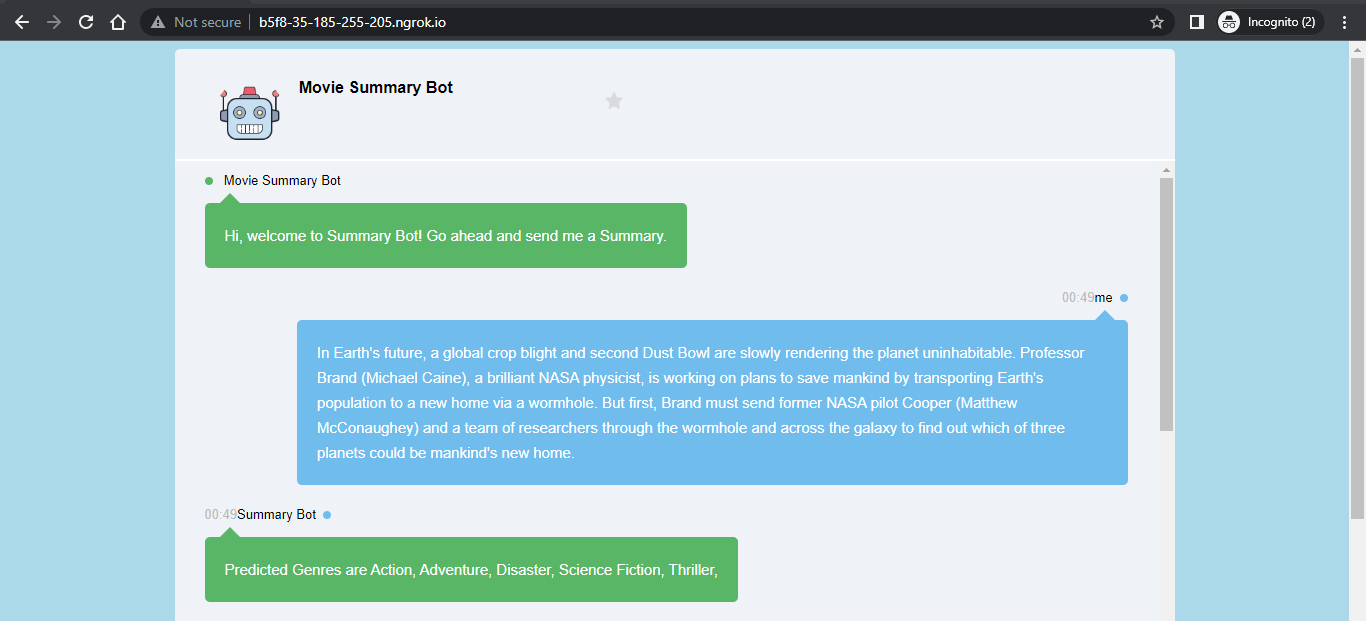

## Conclusion


---

1. In this project we achive 75% validation precison and 98% validation accuracy
2. We served the model using tensorflow model serve
3. We create a client for user to interact using Flask
